In [46]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [47]:
width_shape = 190
height_shape = 190
num_classes = 2
batch_size = 32

In [48]:
train_data_dir = 'Nueva carpeta/dataset/train'  
validation_data_dir = 'Nueva carpeta/dataset/valid'

In [49]:
train_datagen = ImageDataGenerator(  
    vertical_flip=False)



valid_datagen = ImageDataGenerator(    
    vertical_flip=False)


train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='categorical')

Found 3600 images belonging to 2 classes.
Found 905 images belonging to 2 classes.


In [50]:
from keras.applications.vgg19 import VGG19


nb_train_samples = 3600
nb_validation_samples = 905


image_input = Input(shape=(width_shape, height_shape, 3))

m_VGG19 = VGG19(input_tensor=image_input, include_top=False,weights='imagenet')


#se entrenan las 6 ultimas capas del modelo y se modifican sus parametros
last_layer = m_VGG19.layers[-1].output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu', name='fc2')(x)
x=Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_VGG19_model = Model(image_input, out)


# freeze all the layers except the dense layers
for layer in custom_VGG19_model.layers[:-6]:
	layer.trainable = False

epochs = 5
    
custom_VGG19_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

model_history = custom_VGG19_model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

Epoch 1/5
112/112 [==============================] - 1465s 13s/step - loss: 1.1098 - accuracy: 0.8551 - val_loss: 0.0349 - val_accuracy: 0.9453
Epoch 2/5
112/112 [==============================] - 1459s 13s/step - loss: 0.1819 - accuracy: 0.9552 - val_loss: 0.0523 - val_accuracy: 0.9496
Epoch 3/5
112/112 [==============================] - 1457s 13s/step - loss: 0.0794 - accuracy: 0.9804 - val_loss: 0.2230 - val_accuracy: 0.9496
Epoch 4/5
112/112 [==============================] - 1444s 13s/step - loss: 0.0942 - accuracy: 0.9815 - val_loss: 1.1527 - val_accuracy: 0.9633
Epoch 5/5
112/112 [==============================] - 1446s 13s/step - loss: 0.0609 - accuracy: 0.9896 - val_loss: 0.7419 - val_accuracy: 0.9519


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 190, 190, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 190, 190, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 190, 190, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 95, 95, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 95, 95, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 95, 95, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 47, 47, 128)       0     

In [51]:
custom_VGG19_model.save("models/models1_VGG19.h5")

In [52]:
def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)
    


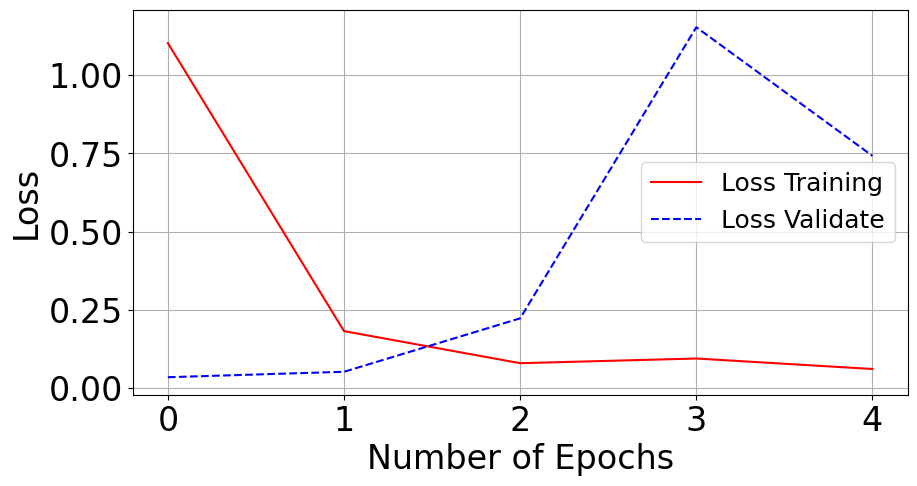

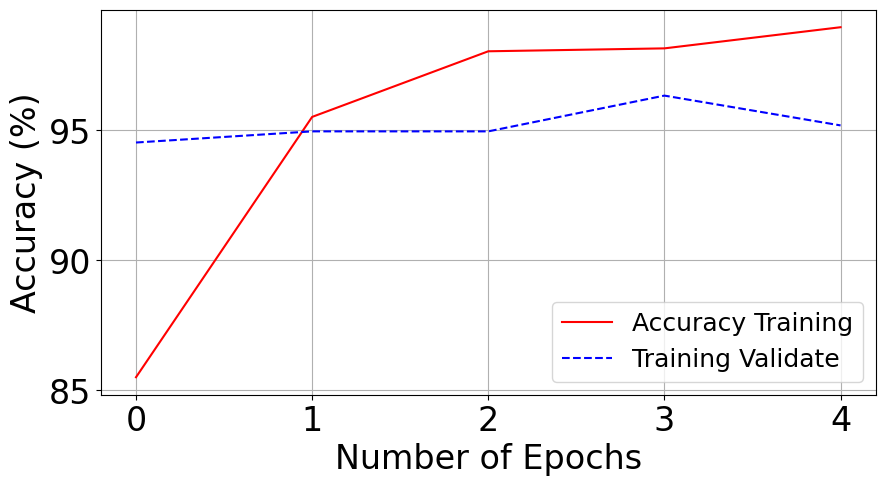

In [53]:
plotTraining(model_history,epochs,"loss")
plotTraining(model_history,epochs,"accuracy")
plotTraining(model_history,epochs,"val_loss")
plotTraining(model_history,epochs,"val_accuracy")

Found 905 images belonging to 2 classes.
              precision    recall  f1-score   support

           0     0.9684    0.9429    0.9555       455
           1     0.9437    0.9689    0.9561       450

    accuracy                         0.9558       905
   macro avg     0.9561    0.9559    0.9558       905
weighted avg     0.9561    0.9558    0.9558       905



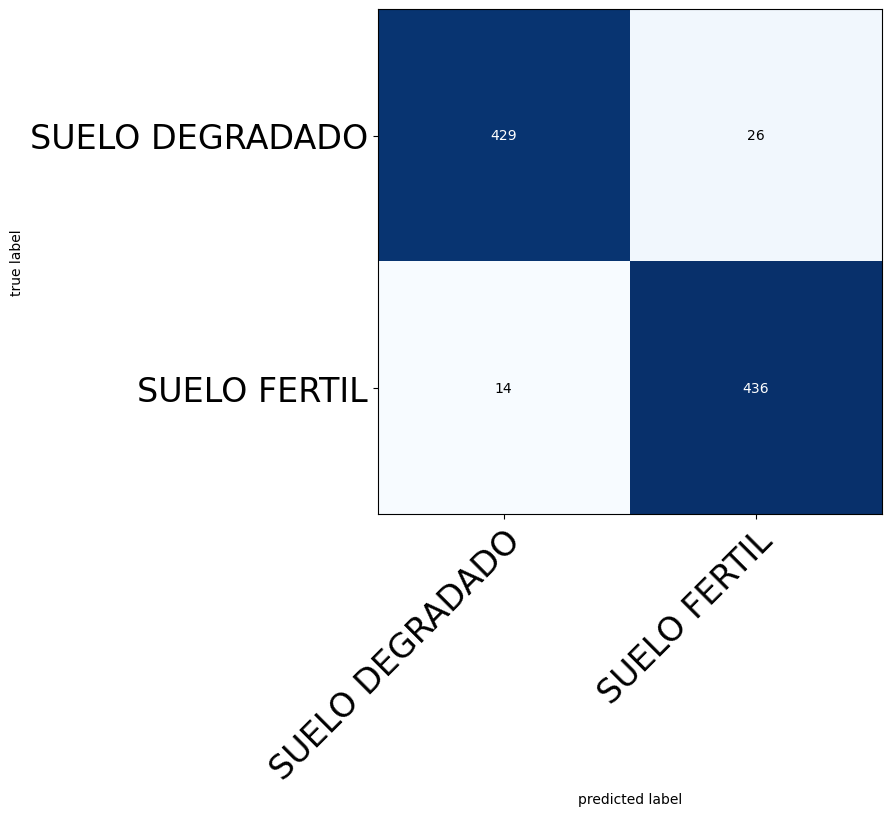

In [54]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


names = ['SUELO DEGRADADO','SUELO FERTIL']


train_data_dir = 'Nueva carpeta/dataset/valid'  

train_datagen = ImageDataGenerator()

validation_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size=(width_shape, height_shape), 
    batch_size = batch_size,
    class_mode='categorical', 
    shuffle=False)



custom_Model= load_model("models/models1_VGG19.h5")

predictions = custom_Model.predict_generator(generator=validation_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = validation_generator.classes


matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(9,9), class_names = names, show_normed=False)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))

Modelo cargado exitosamente
Predicción
Predicción: SUELO FERTIL


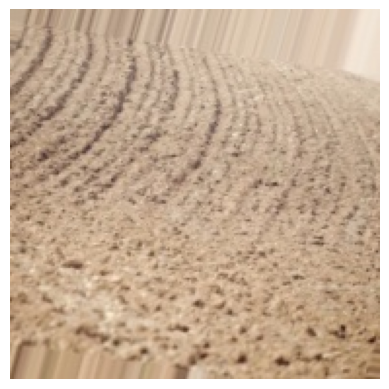

In [45]:
from keras.applications.imagenet_utils import preprocess_input
from keras.models import load_model

import numpy as np
import cv2
import matplotlib.pyplot as plt


width_shape = 190
height_shape = 190


names = ['SUELO DEGRADADO POR SALINIDAD','SUELO FERTIL']



modelt = load_model("models/models_VGG19.h5")
print("Modelo cargado exitosamente")

imaget_path = "Nueva carpeta/dataset/valid/SUELO FERTIL/2782.jpg"
imaget=cv2.resize(cv2.imread(imaget_path), (width_shape, height_shape), interpolation = cv2.INTER_AREA)

xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)

print("Predicción")
preds = modelt.predict(xt)

print("Predicción:", names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()